In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
# Settings & Paths

url_data_source = 'https://github.com/washingtonpost/data-police-shootings'
pic_path = 'plots/{name}'

plt.rcParams["figure.figsize"] = (10,10)
# plt.rc("figure", figsize=(10, 10))
sns.set_style('whitegrid')

# 1. Police fatal shooting since 2015

The Washington Post's database contains records of every fatal shooting in the United States by a police officer in the line of duty since Jan. 1, 2015.

In 2015, The Post began tracking more than a dozen details about each killing — including the race of the deceased, the circumstances of the shooting, whether the person was armed and whether the person was experiencing a mental-health crisis — by culling local news reports, law enforcement websites and social media, and by monitoring independent databases such as Killed by Police and Fatal Encounters. The Post conducted additional reporting in many cases
.

In [3]:
df_pb = pd.read_csv('raw_data/fatal-police-shootings-data.csv')

print('df shape:', df_pb.shape)
df_pb.head()

df shape: (6211, 17)


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


In [4]:
# Drop useless columns
cols = ['name', 'flee', 'body_camera', 'is_geocoding_exact', 'longitude', 'latitude']
df_pb = df_pb.drop(cols, axis='columns')

In [5]:
# Describe numeric values

df_pb.describe()

,id,age
count,6211.000000,5933.000000
mean,3442.510063,37.120681
std,1942.636455,13.013878
min,3.000000,6.000000
25%,1755.500000,27.000000
50%,3449.000000,35.000000
75%,5130.500000,46.000000
max,6777.000000,91.000000


In [6]:
# handling missing values

# Replace with unknown string
df_pb[['armed', 'race']] = df_pb[['armed', 'race']].replace(np.nan, 'unknown', regex=True)
df_pb.dropna(subset=['gender'], axis=0, inplace=True)

# Replace with mean / median
df_pb.age.fillna(method='ffill', inplace=True, axis=0)

df_pb.isnull().sum()

id                         0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
dtype: int64

Race Encoding

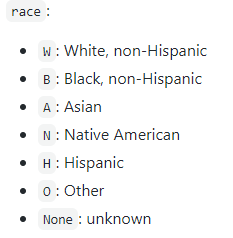


In [7]:
# Encoding races

races_encoding = {'W':'White', 'B':'Black', 'A':'Asian', 'N':'Native American', 'H':'Hispanic', 'O':'Other'}

df_pb['race'] = df_pb.race.replace(races_encoding)

df_pb.race.unique()

array(['Asian', 'White', 'Hispanic', 'Black', 'Other', 'unknown',
       'Native American'], dtype=object)

In [8]:
print(df_pb.armed.unique())

['gun' 'unarmed' 'toy weapon' 'nail gun' 'knife' 'unknown' 'shovel'
 'vehicle' 'hammer' 'hatchet' 'sword' 'machete' 'box cutter'
 'undetermined' 'metal object' 'screwdriver' 'lawn mower blade' 'flagpole'
 'guns and explosives' 'cordless drill' 'crossbow' 'BB gun' 'metal pole'
 'Taser' 'metal pipe' 'metal hand tool' 'blunt object' 'metal stick'
 'sharp object' 'meat cleaver' 'carjack' 'chain' "contractor's level"
 'railroad spikes' 'stapler' 'beer bottle' 'unknown weapon' 'binoculars'
 'bean-bag gun' 'baseball bat and fireplace poker' 'straight edge razor'
 'gun and knife' 'ax' 'brick' 'baseball bat' 'hand torch' 'chain saw'
 'garden tool' 'scissors' 'pole' 'pick-axe' 'flashlight' 'baton' 'spear'
 'chair' 'pitchfork' 'hatchet and gun' 'rock' 'piece of wood' 'bayonet'
 'pipe' 'glass shard' 'motorcycle' 'pepper spray' 'metal rake' 'crowbar'
 'oar' 'machete and gun' 'tire iron' 'air conditioner' 'pole and knife'
 'baseball bat and bottle' 'fireworks' 'pen' 'chainsaw' 'gun and sword'
 'gun 

In [9]:
# Optimise data types

df_pb.date = pd.to_datetime(df_pb.date)
df_pb[['race', 'gender']] = df_pb[['race', 'gender']].astype('category')
df_pb.dtypes

id                                  int64
date                       datetime64[ns]
manner_of_death                    object
armed                              object
age                               float64
gender                           category
race                             category
city                               object
state                              object
signs_of_mental_illness              bool
threat_level                       object
dtype: object

# EDA 

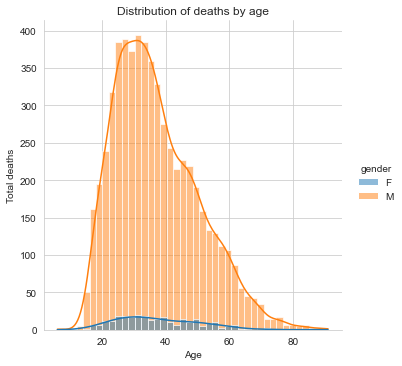

In [10]:
# Distribution of data

sns.displot(data=df_pb, x='age', hue='gender', color='blue', kde=True)
plt.title('Distribution of deaths by age') # Right skeweness 
plt.ylabel('Total deaths')
plt.xlabel('Age')
plt.savefig(pic_path.format(name='1_data_by_age_distribution'), bbox_inches='tight')

plt.show()

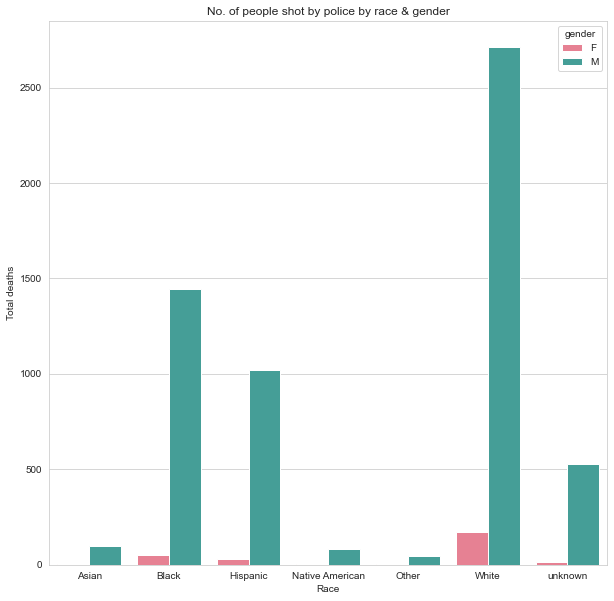

In [11]:
# Countplot of shots by gender

sns.countplot(data=df_pb, x='race', hue='gender', palette='husl')
plt.title('No. of people shot by police by race & gender')
plt.ylabel('Total deaths')
plt.xlabel('Race')
plt.savefig(pic_path.format(name='2_countplot_gender_deaths'), bbox_inches='tight')

plt.show()

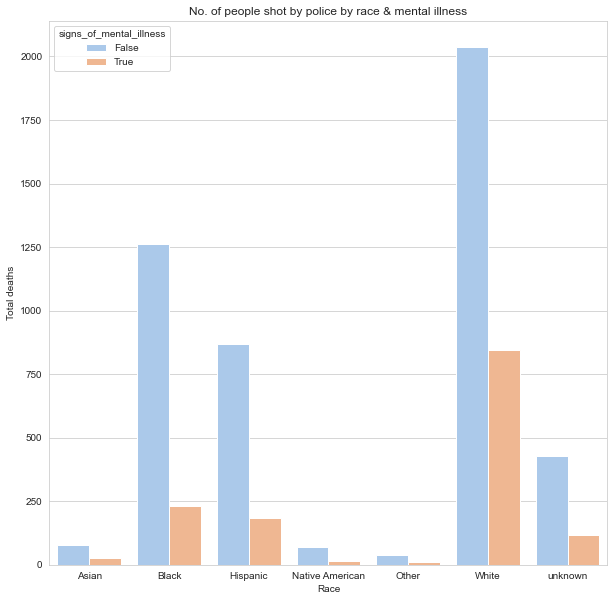

In [12]:
# Countplot of shots by mental illness

sns.countplot(data=df_pb, x='race', hue='signs_of_mental_illness', palette='pastel')
plt.title('No. of people shot by police by race & mental illness')
plt.ylabel('Total deaths')
plt.xlabel('Race')
plt.savefig(pic_path.format(name='3_countplot_illness_deaths'), bbox_inches='tight')

plt.show()

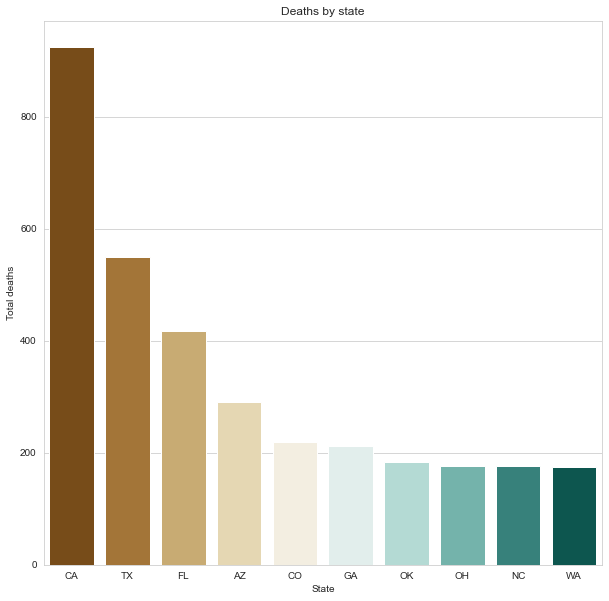

In [13]:
# Heatmap categorical vars

sns.barplot(x=df_pb.groupby(by='state').size().sort_values(ascending=False).head(10).index, 
              y=df_pb.groupby(by='state').size().sort_values(ascending=False).head(10).values, 
           palette='BrBG')

plt.title('Deaths by state')
plt.ylabel('Total deaths')
plt.xlabel('State')
plt.savefig(pic_path.format(name='4_countplot_state_deaths'), bbox_inches='tight')

plt.show()

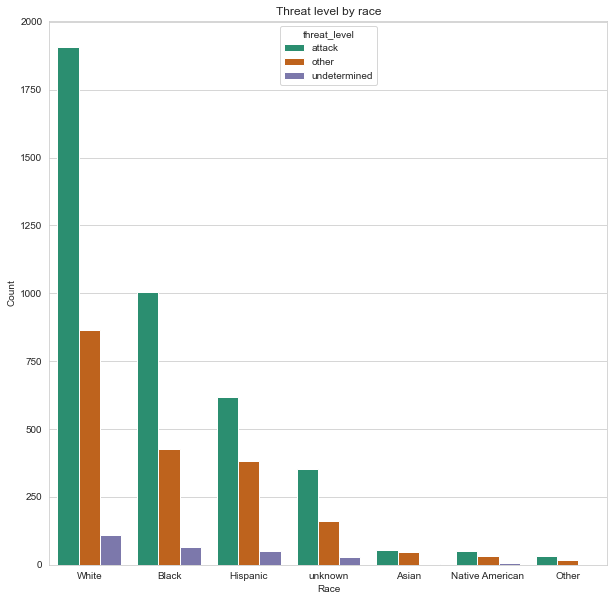

In [14]:
# Countplot by threat level on the police officer

sns.countplot(data=df_pb, x='race', hue='threat_level', palette='Dark2', order=df_pb.race.value_counts().index)

plt.title('Threat level by race')
plt.ylabel('Count')
plt.xlabel('Race')
plt.savefig(pic_path.format(name='5_countplot_threat_level_race'), bbox_inches='tight')

plt.show()